In [1]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
from itertools import product
from turtle import shape
import pygad
import pandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']   
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel('酶复配数据集.xlsx')
data = data.drop_duplicates()


In [2]:
enzyme1, assistant1 = 'Ba', 'AKD'
enzyme2, assistant2 ='XYN', 'AKD'


data_index1 = (data['酶'] == enzyme1) & (data['助剂'] == assistant1)
data_index2 = (data['酶'] == enzyme2) & (data['助剂'] == assistant2)

In [3]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

<Axes: >

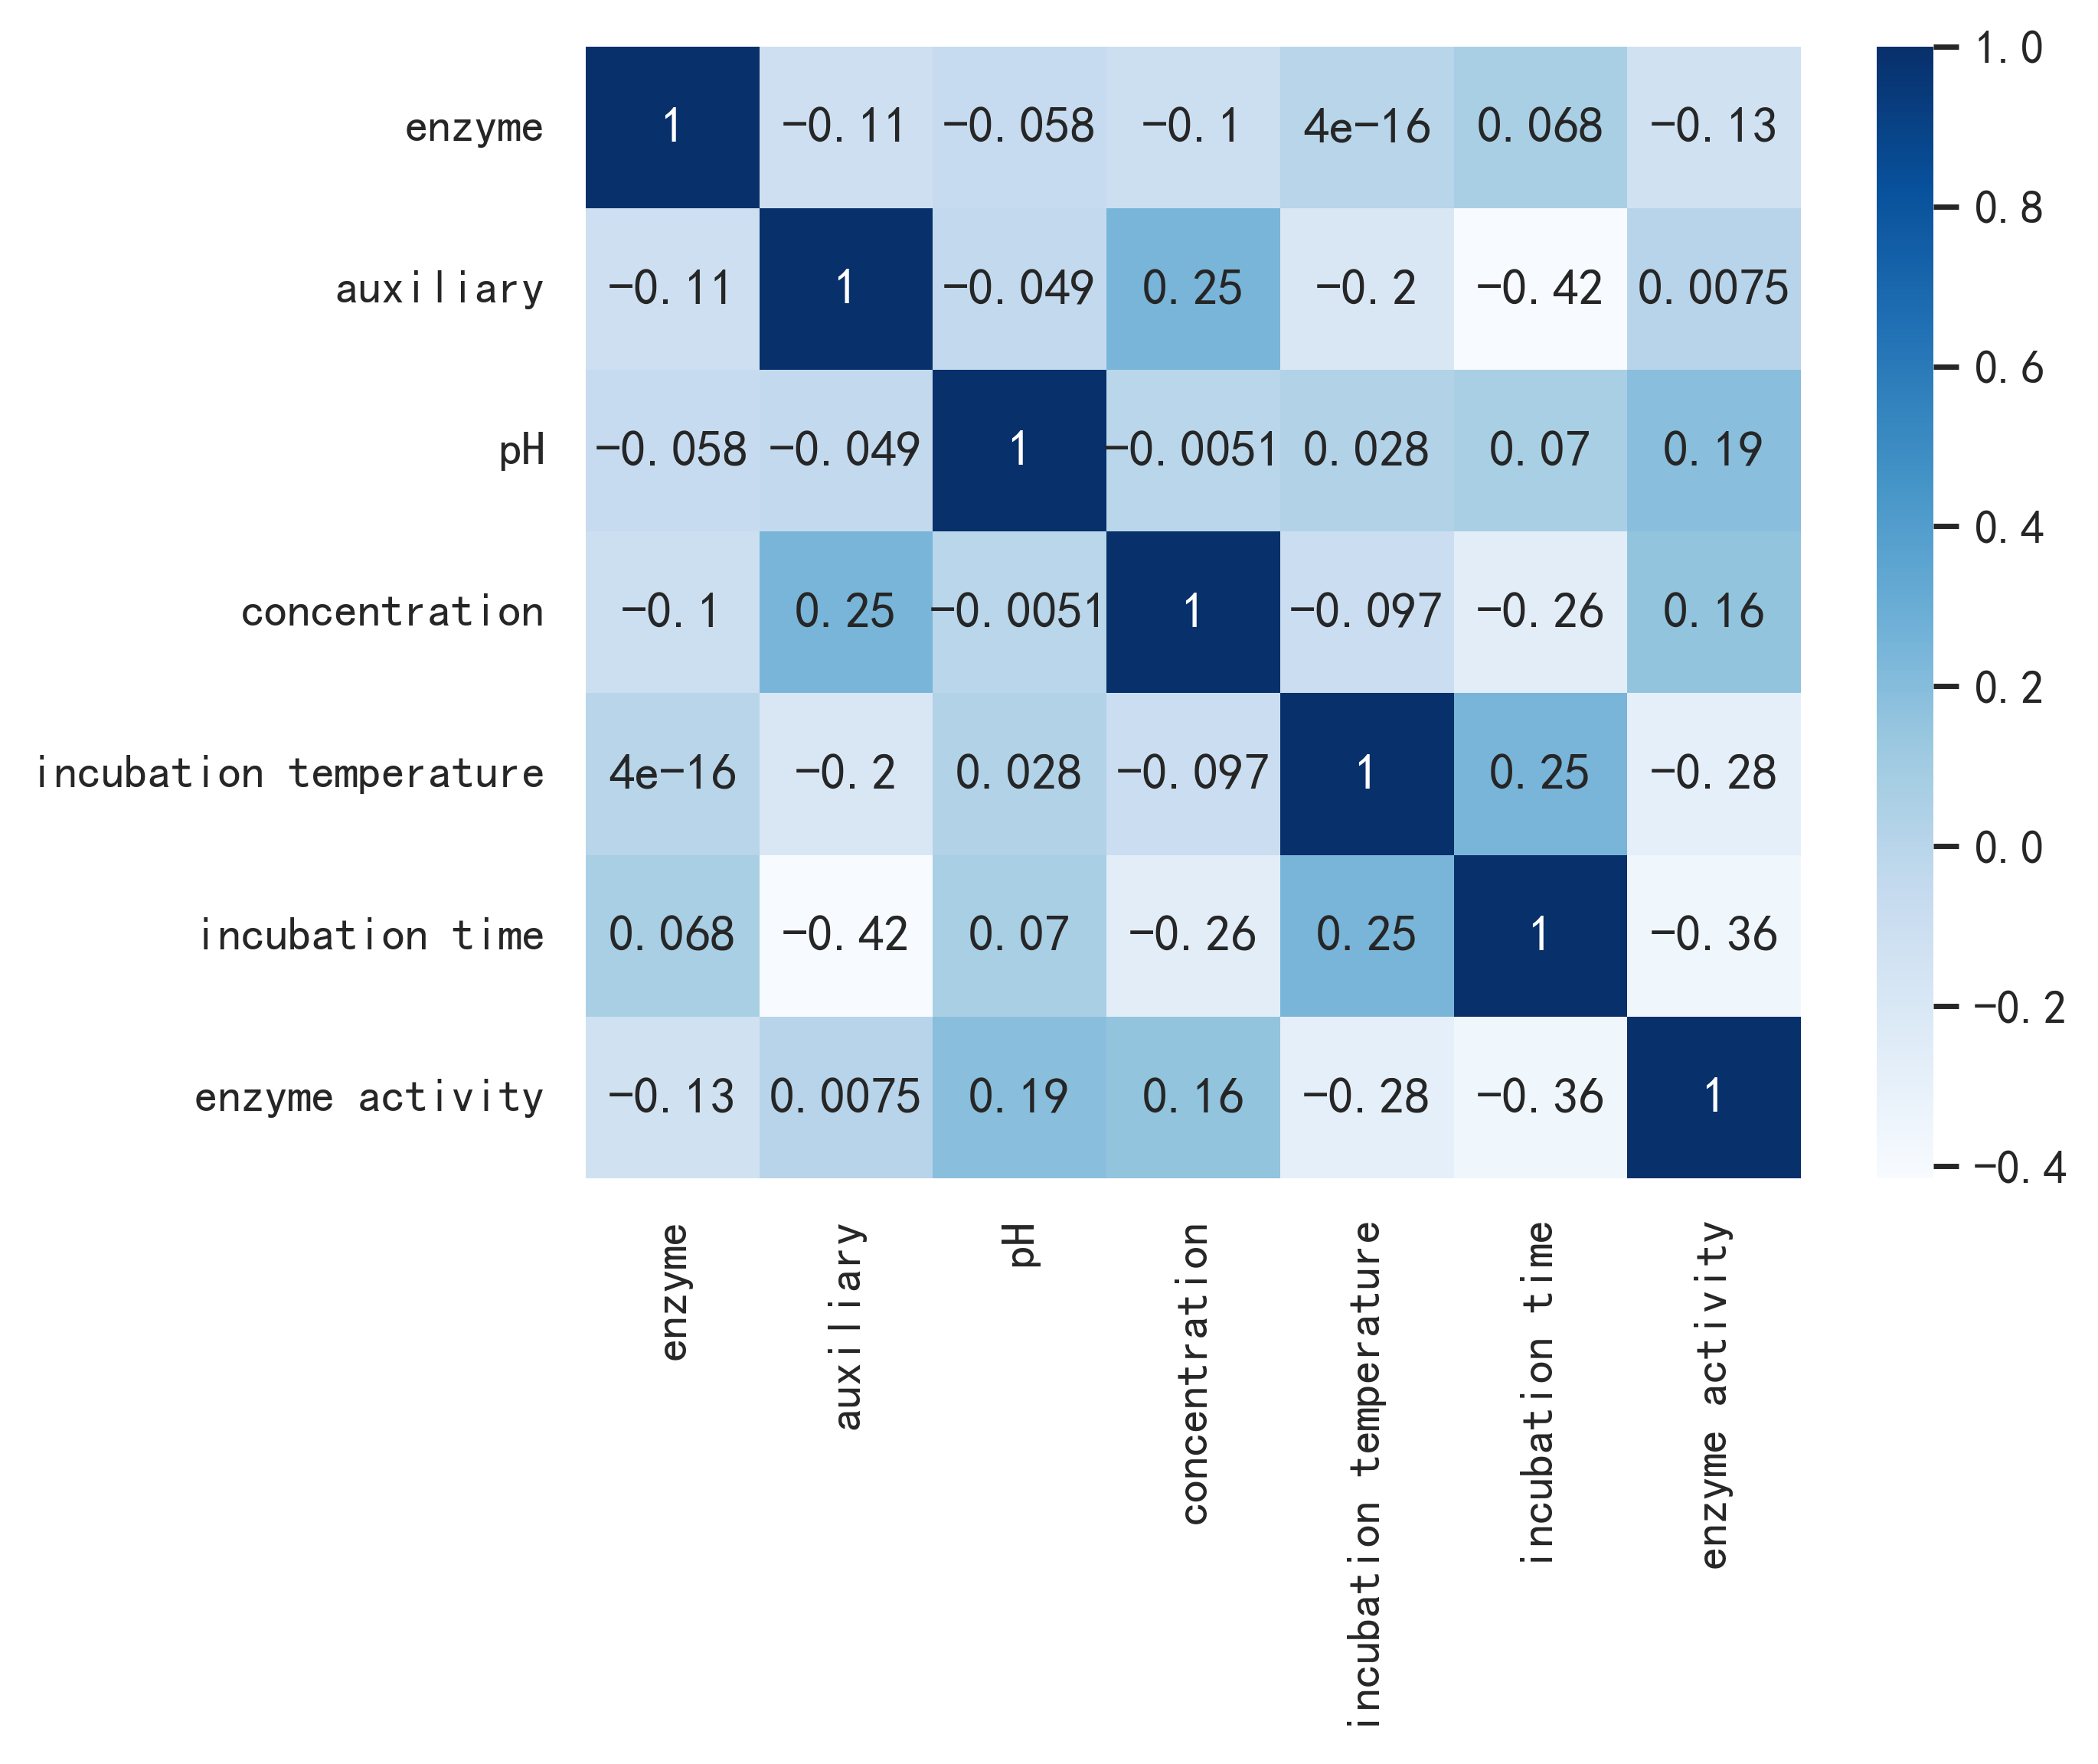

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
sns.set(font='SimHei') 
data_2 = pd.read_excel('酶复配数据集.xlsx')
data_2['酶'] = label_encoder.fit_transform(data_2['酶'])
data_2['助剂'] = label_encoder.fit_transform(data_2['助剂'])
data_2 = data_2.rename(columns={'酶': 'enzyme'})
data_2 = data_2.rename(columns={'助剂':'auxiliary'})
data_2 = data_2.rename(columns={'浓度':'concentration'})
data_2 = data_2.rename(columns={'孵育温度':'incubation temperature'})
data_2 = data_2.rename(columns={'孵育时间':'incubation time'})
data_2 = data_2.rename(columns={'酶活':'enzyme activity'})
features_all2 = data_2.corr()    
plt.figure(dpi=400)
ax = sns.heatmap(features_all2,cmap = 'Blues',annot =True )
sns.set_theme(style="whitegrid",font='Times New Roman',font_scale=1.5)
plt.savefig('MLP模型单酶预测热力图.jpg', dpi=600, bbox_inches='tight')
ax

In [5]:
x_ = data.drop(columns=['酶活'], axis=1)
y_ = data['酶活']
scaler = MinMaxScaler()
scaler.fit(x_) 
x_transfer = scaler.transform(x_) 
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_transfer,y_,test_size = 0.2,random_state = 44) 

In [6]:
mlp_ = MLPRegressor(
        hidden_layer_sizes=(100,50), activation='relu',solver='adam',alpha=0.01,max_iter=200)

In [7]:
mlp_model_ = mlp_.fit(x_train_, y_train_)

In [8]:
pre1 = mlp_model_.predict(x_train_)
pre2 = mlp_model_.predict(x_test_)
R2_1 = r2_score(y_train_,pre1)
R2_2 = r2_score(y_test_,pre2)
print("train_model's R2: {:.4f}".format(R2_1))
print("test_model's R2: {:.4f}".format(R2_2))
mse_train_ = np.mean(np.power(y_train_ - pre1, 2))
mse_test_ = np.mean(np.power(y_test_ - pre2, 2))
print("train_model's MSE: {:.4f}".format(mse_train_))
print("test_model's MSE: {:.4f}".format(mse_test_))
print("train_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_train_,pre1)))
print("test_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_test_,pre2)))

train_model's R2: 0.5079
test_model's R2: 0.3643
train_model's MSE: 0.0734
test_model's MSE: 0.0649
train_model's RMSE: 0.27100056112241416
test_model's RMSE: 0.25468694347851994


In [9]:
data1 = data[data_index1]
data2 = data[data_index2]
X1 = data1[['pH', '浓度', '孵育温度', '孵育时间']]
X2 = data2[['pH', '浓度', '孵育温度', '孵育时间']]
y1 = data1['酶活']
y2 = data2['酶活']


In [10]:
def used_model(X_train, y_train): 
    mlp = MLPRegressor(
        hidden_layer_sizes=(100,50), activation='relu',solver='adam',alpha=0.01,max_iter=200)
    mlp_model = mlp.fit(X_train, y_train)
    return mlp_model
    # 返回模型

In [11]:
def remove_duplicates(arr):
    _, idx = np.unique(arr, axis=0, return_index=True)
    return arr[np.sort(idx)]

def gaga(gp, gp2):
    last_fitness = 0

    def fitness_func(index, solution, solution_idx):
        pred = gp.predict([solution])
        pred2 = gp2.predict([solution])
        Z = pred[0]+pred2[0]
        return Z

    def on_generation(ga_instance):
        global last_fitness
        last_fitness = ga_instance.best_solution(
            pop_fitness=ga_instance.last_generation_fitness)[1]

    last_fitness = 0
    # 调用pygad
    ga_instance = pygad.GA(num_generations=100,  # 可调参数
                           num_parents_mating=8,  # 可调参数
                           sol_per_pop=10,  # 可调参数
                           num_genes=4,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes='default',
                           # 此处可挑输出指标数值范围 range(7, 9, 1) 为pH的取值范围 7最小 9最大 1为步长 若要步长为小数应把range换np.arange
                           gene_space=[range(7, 9, 1), np.arange(0.001, 0.1, 0.002), range(30, 80, 10), range(20, 80, 10)],
                           mutation_by_replacement=True,
                           fitness_func=fitness_func,
                           on_generation=on_generation,
                           save_solutions=True,
                           random_seed=36)

    ga_instance.run()
    ga_instance.plot_result()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    ga_s = np.array(ga_instance.solutions)
    ga_sf = np.array(ga_instance.solutions_fitness)
    ga_res = np.c_[ga_s,ga_sf]
    sort_idx = np.argsort(ga_res[:, 4])[::-1]
    # 使用sort_idx对原数组进行重排
    sorted_arr = ga_res[sort_idx]
    sorted_arr = remove_duplicates(sorted_arr)
    nums_pf = 15  # 前几个配方  可改参数
    score = sorted_arr[:nums_pf, 4]
    score = (score / score[0]) * 100
    print('输入的酶和助剂分别为：')
    print(enzyme1, assistant1)
    print(enzyme2, assistant2)
    print("最佳反应条件为 pH:{}, 浓度:{:.2f}, 温度:{}, 孵育时间:{}".format(solution[0], solution[1],solution[2],solution[3]))
    print('----------------------------------')
    print('推荐反应条件')
    print('pH\t 浓度\t\t 温度\t 孵育时间\t 评分')
    for i in range(nums_pf):
        print(sorted_arr[i][0], '\t', '{:.4f}'.format(sorted_arr[i][1]), '\t',
              sorted_arr[i][2], '\t', sorted_arr[i][3], '\t''\t',
              '{:.2f}'.format(score[i]))


In [12]:
gp1 = used_model(X1, y1)
gp2 = used_model(X2, y2)
gaga(gp1, gp2)

输入的酶和助剂分别为：
Ba AKD
XYN AKD
最佳反应条件为 pH:8.0, 浓度:0.10, 温度:50.0, 孵育时间:70.0
----------------------------------
推荐反应条件
pH	 浓度		 温度	 孵育时间	 评分
8.0 	 0.0970 	 50.0 	 70.0 		 100.00
8.0 	 0.0950 	 50.0 	 70.0 		 99.99
8.0 	 0.0930 	 50.0 	 70.0 		 99.98
8.0 	 0.0910 	 50.0 	 70.0 		 99.98
8.0 	 0.0890 	 50.0 	 70.0 		 99.97
8.0 	 0.0870 	 50.0 	 70.0 		 99.96
8.0 	 0.0850 	 50.0 	 70.0 		 99.95
8.0 	 0.0830 	 50.0 	 70.0 		 99.94
8.0 	 0.0790 	 50.0 	 70.0 		 99.93
8.0 	 0.0770 	 50.0 	 70.0 		 99.92
8.0 	 0.0730 	 50.0 	 70.0 		 99.90
8.0 	 0.0710 	 50.0 	 70.0 		 99.90
8.0 	 0.0690 	 50.0 	 70.0 		 99.89
8.0 	 0.0650 	 50.0 	 70.0 		 99.87
8.0 	 0.0630 	 50.0 	 70.0 		 99.86


model's R2: 0.6242
model's MSE: 0.0317
model's RMSE: 0.17793346361687182


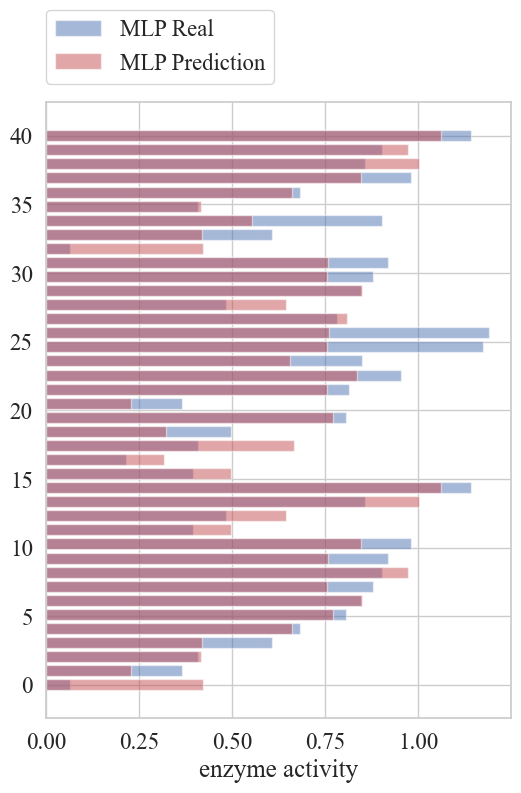

In [13]:
from sklearn.metrics import r2_score
pre1 = gp1.predict(X1)
pre2 = gp1.predict(X2)
pre = np.concatenate((pre1, pre2))
y = np.concatenate((y1, y2))

R2 = r2_score(y,pre)
SSR = np.sum((y-pre)**2)
SST = np.sum((y-np.mean(y))**2)
r2 = 1 - SSR/(SST+1e-9)
print("model's R2: {:.4f}".format(r2))
mse_test = np.mean(np.power(y - pre, 2))
print("model's MSE: {:.4f}".format(mse_test))
print("model's RMSE:",np.sqrt(metrics.mean_squared_error(y,pre)))


fig = plt.figure(figsize=(6,8))
x = np.linspace(0,y.shape[0],y.shape[0])
plt.barh(x,y,color='b',alpha=0.5,label='MLP Real')
plt.barh(x,pre, color = 'r',alpha=0.5,label='MLP Prediction')
plt.xlabel("enzyme activity")
plt.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0)
plt.savefig('MLP模型多酶预测柱状图图.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
data_seaborn = pd.DataFrame()
data_seaborn['enzyme activity_true'] = y
data_seaborn['enzyme activity_pred'] = pre

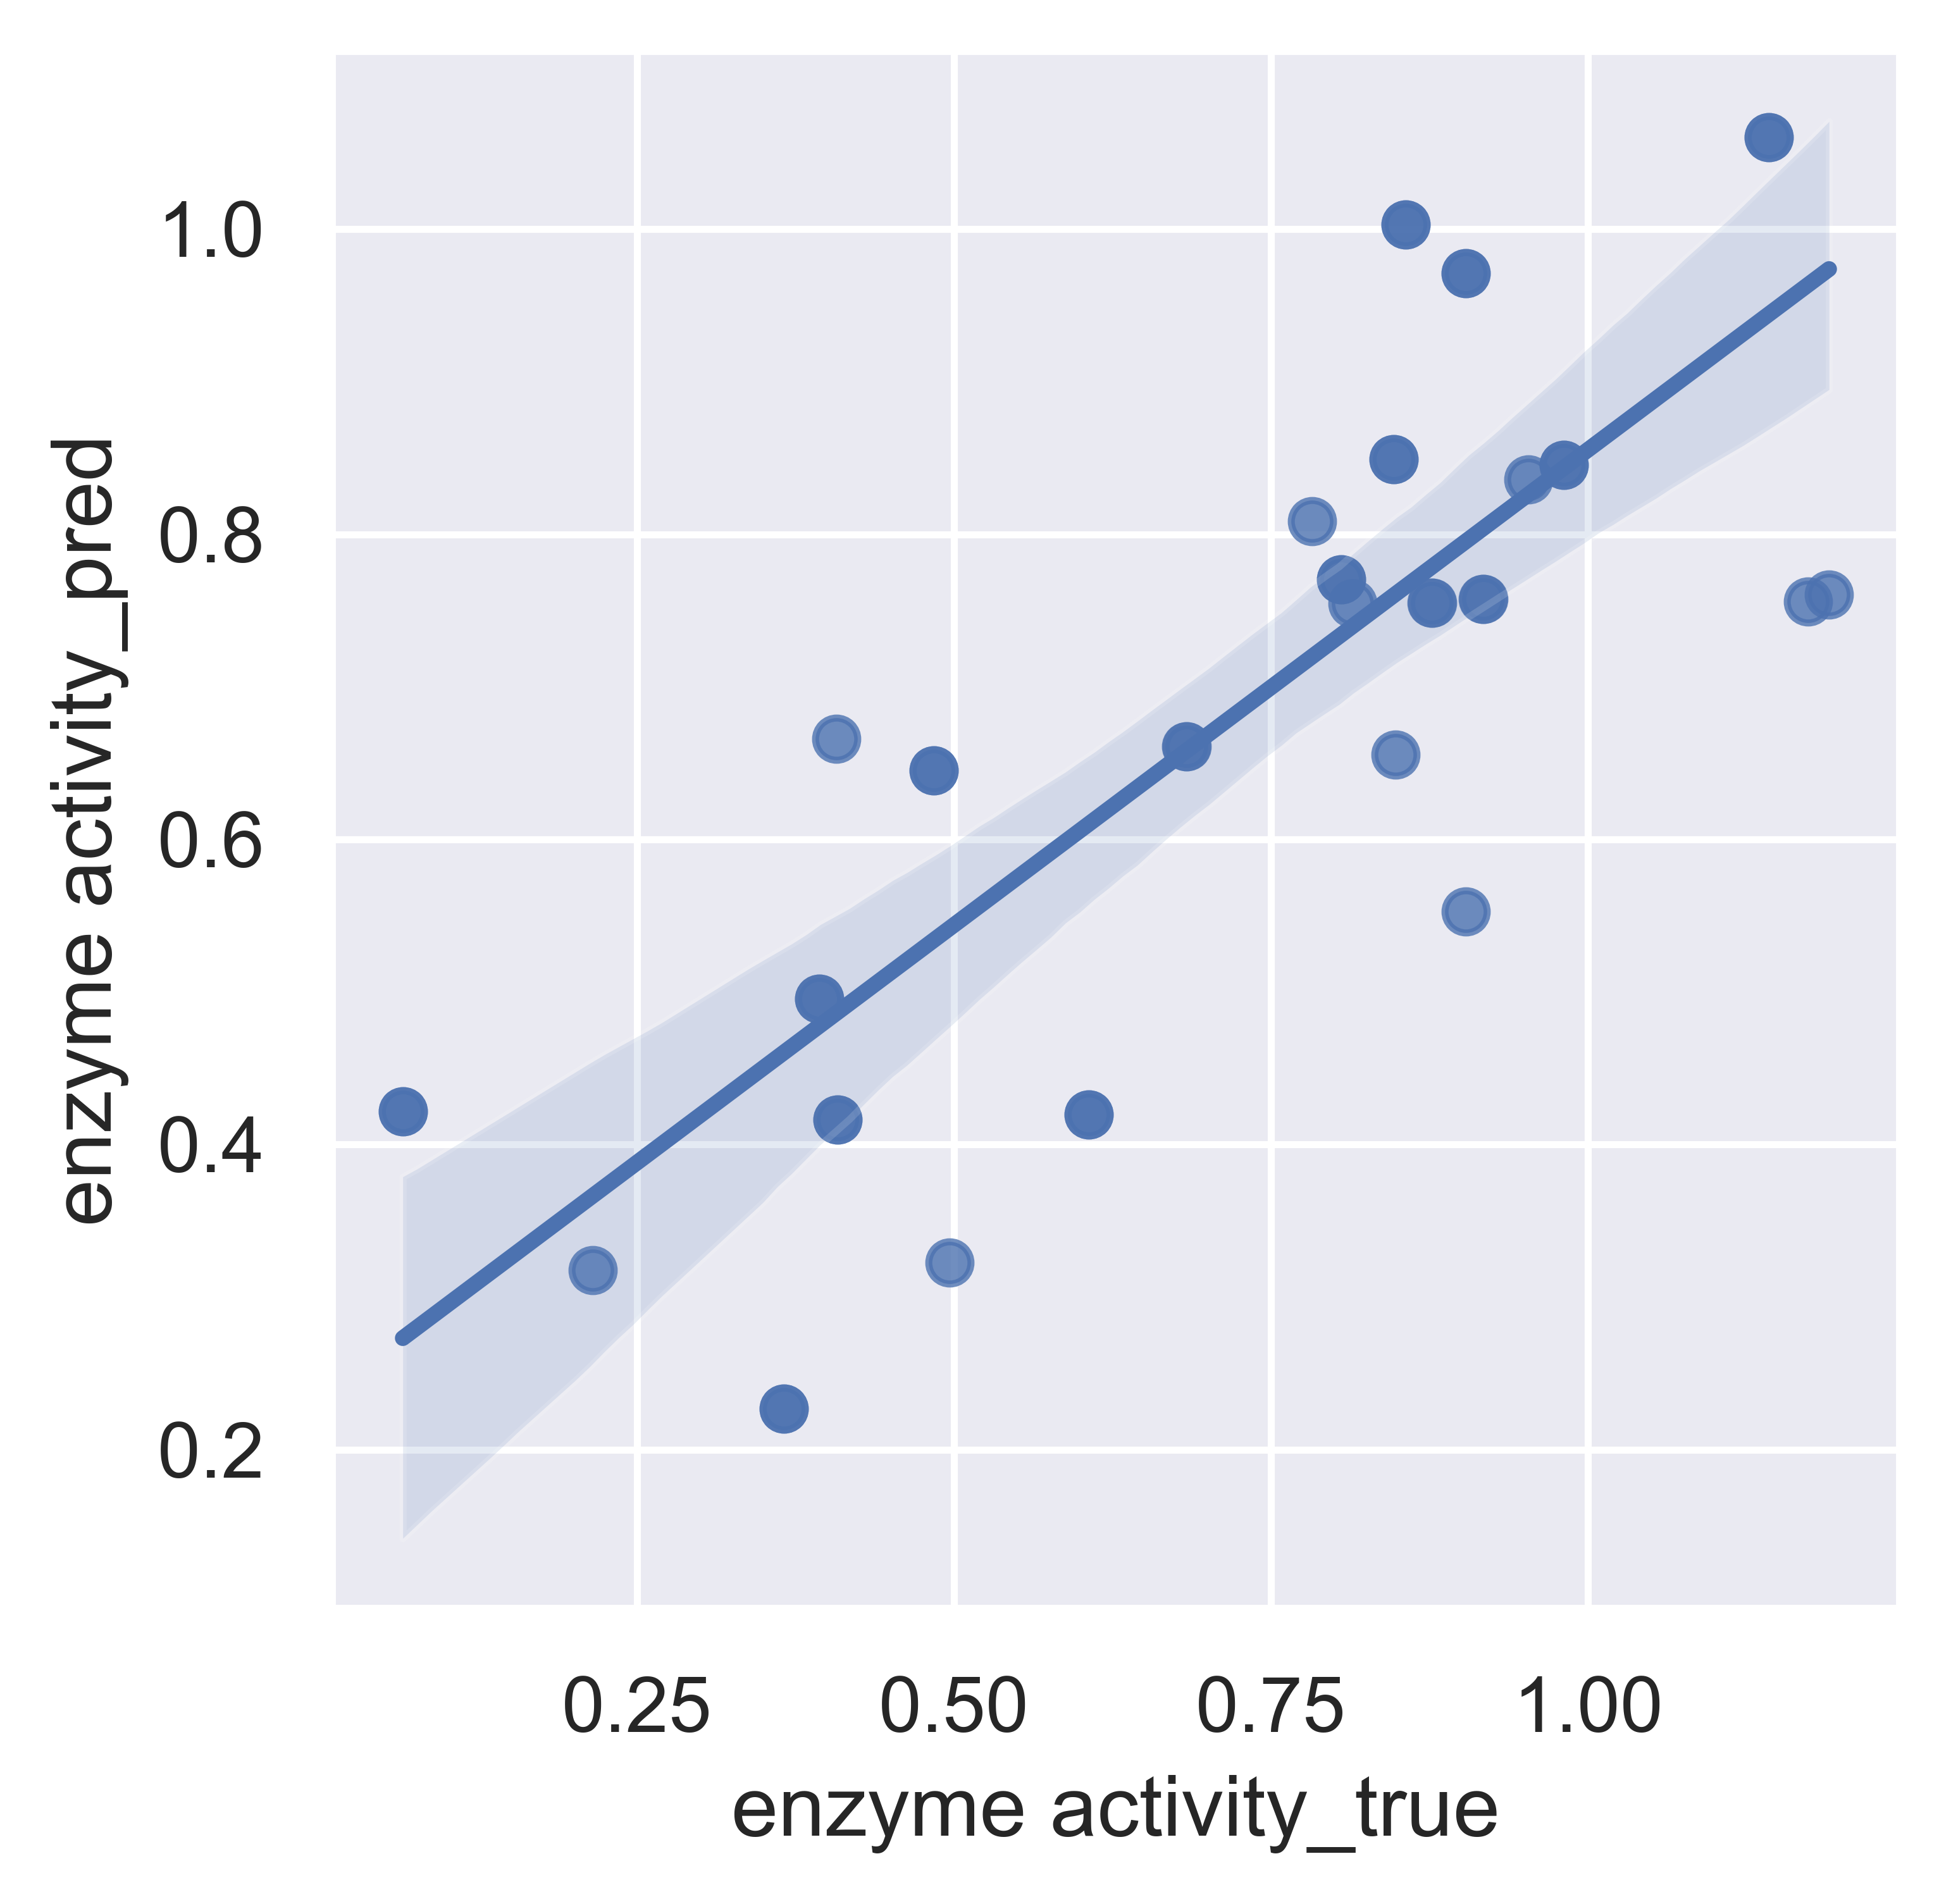

In [15]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
plt.figure(dpi=800, figsize=(4,4))
sns.set(font='SimHei')
sns.set(color_codes=True)
sns.regplot(x=data_seaborn['enzyme activity_true'],y=data_seaborn['enzyme activity_pred'])
plt.savefig('MLP模型多酶预测线性回归图.jpg', dpi=600, bbox_inches='tight')